# Tutorial 2:

In this tutorial we are going to work with Lasso, Ridge-regression and Principal Components Analysis (PCA). As an example, we are going to use [McCracken's Monthly and Quarterly Databases for Macroeconomic Research](https://research.stlouisfed.org/econ/mccracken/fred-databases/). The databases offer real-time vintages on many US macroeconomic variables. For those of you who are not familiar, there is an important difference (among other things) between, e.g., financial market data and macroeconomic data. Data on stock prices for example is almost immediately available and "fixed". It is simply a snapshot of stock market prices at a given point in time. Macroeconomic indicators such as GDP, however, are complicated and costly to compile. They are estimates of the true economic activity and often revised sometimes even years later when new data comes in. Thus past values are subject to change. A so-called data vintage is the current value of the series that is available at that point in time (but might be revised later). A real-time database stores all of these values and thus allows to monitor how a given estimate of, e.g., GDP might have changed over time. Macroeconomic forecasting models that only use real-time data (data that would have been available/known in the past at the time a specific forecast was made) are hence called real-time forecasting models.  

For our small exercise we are going to focus on the current vintage. This means that we are going to use the data that is available right now. Moreover, as a small prediction exercise, we are going to attempt to predict recessions. I am thus going to focus on the Quarterly database here.

In this tutorial:
* Lasso and Ridge Regression: What is the difference?
* Principal Component Analysis
* Computing in-sample and out-of-sample predictions
* Forecasting exercise: Predicting US recessions
* ROC curves

*Note that this exercise is again highly stylized. We look at cross-sectional predictions of GDP. In reality, predicting future GDP growth is a more important and interesting exercise.*

### 1.0 Setup:

In [1]:
# import Python packages
%matplotlib inline  
import pandas as pd 
import numpy as np  
import scipy as sp 
from scipy import stats
import matplotlib.pyplot as plt
from functools import reduce
from IPython.display import Image
plt.rcParams["figure.figsize"] = [10,8]  # Set default figure size

### 1.1 Data:

A complete description of the quarterly data is available [here](https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/FRED-QD_appendix.pdf).

In [2]:
# read-in the .csv file
df = pd.read_csv('current_Q.csv')

# store the transformation information for later
df_transform = df.iloc[1,:]

# delete the first two rows as they contain meta-information
df = df.iloc[2:,:]

# transform the date series into datetime values
df['sasdate'] = df['sasdate'].astype('datetime64[ns]') 

# set the dates as new index
df = df.set_index('sasdate')

# display the data 
df.head()

,GDPC1,PCECC96,PCDGx,PCESVx,PCNDx,GPDIC1,FPIx,Y033RC1Q027SBEAx,PNFIx,PRFIx,...,TLBSNNBx,TLBSNNBBDIx,TABSNNBx,TNWBSNNBx,TNWBSNNBBDIx,CNCFx,S&P 500,S&P: indust,S&P div yield,S&P PE ratio
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-03-01,3121.936,1923.675,76.6269,1228.2525,708.5994,340.604,340.5050,49.2784,169.8803,229.2229,...,315394.42,267125.60,2292458.21,1977.06,1674.49,118.0697,55.5167,59.1400,3.1765,18.6211
1959-06-01,3192.380,1953.384,79.5107,1246.6236,714.4575,367.099,351.0348,50.7534,174.7639,237.2364,...,327311.61,273793.60,2300595.72,1973.28,1650.63,119.5468,57.5067,61.5867,3.1012,19.2899
1959-09-01,3194.653,1973.791,81.0481,1263.5122,717.2159,343.391,354.7551,52.4063,179.4710,232.7918,...,335783.49,275597.47,2300248.57,1964.47,1612.36,121.8384,58.7300,63.0600,3.0720,18.9544
1959-12-01,3203.759,1976.014,77.1760,1278.8229,721.6332,354.567,350.6404,52.3002,178.9702,226.2014,...,330686.41,255408.94,2294980.79,1964.29,1517.14,129.4733,57.7633,62.0200,3.1572,17.8221
1960-03-01,3275.757,1994.918,79.6590,1290.4392,723.4440,390.210,362.3523,54.1198,185.1905,233.1615,...,343374.65,279155.40,2316152.76,1972.78,1603.82,123.0048,56.2767,60.1933,3.3850,16.8284


The dataframe now includes the raw data. `df_transform` contains numbers from 1 to 7 that denote a method of transformation. Before we proceed, let's write a loop that applies these transformations to the data. Luckily, `Pandas` has many methods available that we can use off the shelf. 

In [3]:
# create an emptyh copy of the dataframe, where the indices and column names are the same
df_trans = pd.DataFrame(index=df.index, columns=df.columns)

# loop over the columns of the dataframe 
for i in range(0,df.shape[1]):
    
    # transform data to 'levels', i.e. no change
    if df_transform[i+1] == 1:
        df_trans[df.columns[i]] = df[df.columns[i]]
    
    # transform data to 'first differences'
    elif df_transform[i+1] == 2:
        df_trans[df.columns[i]] = df[df.columns[i]].diff()
    
    # transform data to 'second differences'
    elif df_transform[i+1] == 3:
        df_trans[df.columns[i]] = df[df.columns[i]].diff(periods=2)
        
    # transform data to 'log-levels'
    elif df_transform[i+1] == 4:
        df_trans[df.columns[i]] = np.log(df[df.columns[i]])
        
    # transform data to 'log-differences'
    elif df_transform[i+1] == 5:
        df_trans[df.columns[i]] = np.log(df[df.columns[i]]).diff()
    
    # transform data to 'second log-differences'
    elif df_transform[i+1] == 6:
        df_trans[df.columns[i]] = np.log(df[df.columns[i]]).diff(periods=2)
    
    # transform data to 'percentage changes'
    elif df_transform[i+1] == 7:
        df_trans[df.columns[i]] = df[df.columns[i]].pct_change()

# display the transformed data
df_trans.head()

,GDPC1,PCECC96,PCDGx,PCESVx,PCNDx,GPDIC1,FPIx,Y033RC1Q027SBEAx,PNFIx,PRFIx,...,TLBSNNBx,TLBSNNBBDIx,TABSNNBx,TNWBSNNBx,TNWBSNNBBDIx,CNCFx,S&P 500,S&P: indust,S&P div yield,S&P PE ratio
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,267125.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-06-01,0.022313,0.015326,0.036943,0.014846,0.008233,0.074911,0.030456,0.029493,0.028342,0.034362,...,0.037089,273793.60,0.003543,-0.001914,-23.86,0.012433,0.035218,0.040538,-0.0753,0.035286
1959-09-01,0.000712,0.010393,0.019151,0.013457,0.003853,-0.066762,0.010542,0.032048,0.026578,-0.018913,...,0.025554,275597.47,-0.000151,-0.004475,-38.27,0.018988,0.021049,0.023641,-0.0292,-0.017546
1959-12-01,0.002846,0.001126,-0.048954,0.012045,0.006140,0.032028,-0.011666,-0.002027,-0.002794,-0.028719,...,-0.015296,255408.94,-0.002293,-0.000092,-95.22,0.060779,-0.016597,-0.016630,0.0852,-0.061597
1960-03-01,0.022224,0.009521,0.031666,0.009043,0.002506,0.095788,0.032856,0.034200,0.034166,0.030306,...,0.037652,279155.40,0.009183,0.004313,86.68,-0.051251,-0.026073,-0.029896,0.2278,-0.057371


Due to differencing the data, we lost observations. Also, the dataframe contains two missing values at the end. Before we proceed, let's also delete these values. To make the process more efficient, we can utilize logical operators that return Boolean values. I am not using `.dropna()` here, because the data contains time series that start in 2000. Dropping all rows containing NaNs, we reduce the sample length by 40 years. Since more elaborate techniques of dealing with missing data are beyond the scope of this course, we will simply drop these variables from our set. For that we can use `.dropna(axis = 1)`.  

In [4]:
# here I simply use the df_transform series and the fact that Python reads if statements from top to bottom.
# Checking for two missing values must hence be done first.

# check whether the transformation code contains 2nd differences or 2nd log-differences
if 3 in df_transform.unique() or 6 in df_transform.unique():
    
    # print a message
    print('two missing values at the beginning detected. Deleted the first two rows.')
    # drop the first two observations
    df_trans = df_trans.iloc[2:,:]

# check whether the transformation code contains 1st differences or 1st log-differences or pct. changes
elif 2 in df_transform.unique() or 5 in df_transform.unique() or 7 in df_transform.unique():
    
    # print a meassage
    print('one missing values at the beginning detected. Deleted the first row.')
    
    # drop the first observation
    df_trans = df_trans.iloc[1:,:]

# drop missing values at the end of the sample     
df_trans = df_trans.iloc[:-2,:]
df_trans

two missing values at the beginning detected. Deleted the first two rows.


,GDPC1,PCECC96,PCDGx,PCESVx,PCNDx,GPDIC1,FPIx,Y033RC1Q027SBEAx,PNFIx,PRFIx,...,TLBSNNBx,TLBSNNBBDIx,TABSNNBx,TNWBSNNBx,TNWBSNNBBDIx,CNCFx,S&P 500,S&P: indust,S&P div yield,S&P PE ratio
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-09-01,0.000712,0.010393,0.019151,0.013457,0.003853,-0.066762,0.010542,0.032048,0.026578,-0.018913,...,0.025554,275597.47,-0.000151,-0.004475,-38.27,0.018988,0.021049,0.023641,-0.0292,-0.017546
1959-12-01,0.002846,0.001126,-0.048954,0.012045,0.006140,0.032028,-0.011666,-0.002027,-0.002794,-0.028719,...,-0.015296,255408.94,-0.002293,-0.000092,-95.22,0.060779,-0.016597,-0.016630,0.0852,-0.061597
1960-03-01,0.022224,0.009521,0.031666,0.009043,0.002506,0.095788,0.032856,0.034200,0.034166,0.030306,...,0.037652,279155.40,0.009183,0.004313,86.68,-0.051251,-0.026073,-0.029896,0.2278,-0.057371
1960-06-01,-0.005408,0.012535,0.022501,0.011003,0.010896,-0.097837,-0.018342,0.016711,0.014503,-0.085422,...,0.018321,280144.95,0.003057,0.000375,-22.94,0.014782,-0.003680,-0.006778,0.0876,-0.024349
1960-09-01,0.004881,-0.004005,-0.008030,-0.001174,-0.005880,-0.002544,-0.021666,-0.044133,-0.017656,-0.030290,...,0.018804,275164.71,0.007952,0.006017,-47.83,0.036742,-0.006262,-0.012285,0.0276,0.001369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-01,0.006349,0.006681,0.015371,0.005070,0.007590,0.004583,0.006045,-0.004234,0.004623,0.011187,...,0.011539,398824.64,0.013479,0.014888,-7.95,0.029245,0.025918,0.025926,-0.0106,0.004262
2019-12-01,0.005845,0.003927,0.007677,0.005070,-0.001881,-0.009445,0.002433,-0.004197,-0.000867,0.014121,...,0.006991,399935.49,0.004337,0.002409,-0.99,0.004210,0.042307,0.041578,-0.0445,0.035684
2020-03-01,-0.012707,-0.017776,-0.033525,-0.025903,0.017201,-0.023522,-0.003480,-0.041300,-0.017286,0.043444,...,0.018236,440651.07,0.010621,0.005037,47.95,-0.078714,-0.005570,0.004679,0.0698,-0.009700


In [5]:
# drop columns with missing values
df_trans = df_trans.dropna(1)
print('remaining number of variables: ' + str(df_trans.shape[1]))

remaining number of variables: 210


Before we proceed, we split the data into a training and a test sample for out of sample forecasting. 

In [6]:
# conduct a sample split
df_trans_is = df_trans.loc['1959-09-01':'1989-12-01']
df_trans_oos = df_trans.loc['1990-01-01':]

# 2.0 Estimation:

Lasso for example, places a penalty on the size of the coefficients. They should hence be on the same scale, as otherwise certain variables might dominate the analysis. Principal Components Analysis (PCA) works with the variance-covariance matrix of the data. The size of the coefficients again depends on the scale of the variables. Before using regularization techniques like Lasso or Ridge-regression or dimensionality reduction techniques like Principal Component Analysis (PCA), one should hence standardize the input variables.

In [7]:
from sklearn.preprocessing import StandardScaler

# initialize the class
dt_std_is = StandardScaler()
dt_std_oos = StandardScaler()
dt_std_full = StandardScaler()

# compute mean and std. used for computing the z-score
dt_std_is.fit(df_trans_is)
dt_std_oos.fit(df_trans_oos)
dt_std_full.fit(df_trans)

# generate and empty dataframe with the same index and columns as df_trans
df_std_is = pd.DataFrame(index=df_trans_is.index, columns=df_trans_is.columns)
df_std_oos = pd.DataFrame(index=df_trans_oos.index, columns=df_trans_oos.columns)
df_std_full = pd.DataFrame(index=df_trans.index, columns=df_trans.columns)

# filld dataframe with standardized data
df_std_is.iloc[:,:] = dt_std_is.transform(df_trans_is)
df_std_oos.iloc[:,:] = dt_std_oos.transform(df_trans_oos)
df_std_full.iloc[:,:] = dt_std_full.transform(df_trans)
df_std_is

,GDPC1,PCECC96,PCDGx,PCESVx,PCNDx,GPDIC1,FPIx,Y033RC1Q027SBEAx,PNFIx,PRFIx,...,TLBSNNBx,TLBSNNBBDIx,TABSNNBx,TNWBSNNBx,TNWBSNNBBDIx,CNCFx,S&P 500,S&P: indust,S&P div yield,S&P PE ratio
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-09-01,-0.827181,0.165514,0.184578,0.782724,-0.344032,-1.621471,0.009646,0.630888,0.660363,-0.459508,...,0.855415,-0.024799,-1.194756,-1.242417,-0.609325,0.122459,0.103672,0.133033,-0.115945,-0.197943
1959-12-01,-0.606875,-1.046225,-1.768780,0.475368,-0.046663,0.465959,-0.951176,-0.559327,-0.711402,-0.645565,...,-2.618148,-0.654209,-1.485284,-0.753417,-1.738525,1.028546,-0.510552,-0.503357,0.330585,-0.785438
1960-03-01,1.393074,0.051555,0.543534,-0.178226,-0.519232,1.813217,0.974993,0.706046,1.014747,0.474338,...,1.884107,0.086125,0.071355,-0.262020,1.868174,-1.400403,-0.665159,-0.713001,0.887187,-0.729084
1960-06-01,-1.458837,0.445639,0.280646,0.248572,0.571777,-2.278101,-1.239969,0.095171,0.096439,-1.721425,...,0.240367,0.116976,-0.759669,-0.701352,-0.305363,0.031282,-0.299797,-0.347668,0.339953,-0.288673
1960-09-01,-0.396900,-1.717068,-0.595017,-2.402397,-1.609784,-0.264540,-1.383768,-2.030077,-1.405495,-0.675387,...,0.281464,-0.038291,-0.095653,-0.071919,-0.798880,0.507385,-0.341925,-0.434701,0.105759,0.054314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1988-12-01,0.465521,0.284894,0.368983,-0.319619,0.503266,0.109230,0.063584,-0.046841,0.064939,0.022686,...,-0.132337,1.578264,-0.126088,-0.212024,-0.078532,0.176809,0.244019,0.239267,-0.037881,-0.756634
1989-03-01,0.143278,-0.588176,-0.492637,-0.662052,-0.257558,0.494493,-0.062021,-0.072325,0.161329,-0.283273,...,-1.007526,2.372912,-0.640526,-0.288613,1.208895,-1.837448,0.668073,0.678894,-0.398149,-0.245961
1989-06-01,-0.115876,-0.584477,0.015535,-1.266311,-0.644553,-0.416169,-0.390063,0.256825,0.046201,-0.703410,...,-0.877837,2.045340,-0.771613,-0.529927,-0.330743,0.478955,0.981784,0.868489,-0.585505,0.085978


### 2.1 Lasso & Ridge-Regression:

The difference between Lasso and Ridge-regression lies in the penalty term. While Lasso penalizes the sum of absolute coefficients, Ridge-regression penalizes the sum of squared coefficients. This has two major implications. 
First, due to the absolute term, we cannot compute first order conditions of Lasso. It thus does not have an analytical solution and we have to resort to numerical methods to solve the optimization problem. For Ridge-Regression, however, an analytical solution does exist. 

The Second implication becomes obvious in the figure below. Here a convex set (depicted by the red line) lies tangent to the constraint regions of Lasso and Ridge-Regression, respectively. For Lasso this set is likely to hit a corner of the constraint region which results in coefficients that are exactly zero. In case of Ridge-Regression, however, the tangent is equally likely to hit a point for which the coefficients are zero or any other point. This is why Lasso can result in coefficients that are exactly zero, while Ridge-Regression generally does not. 

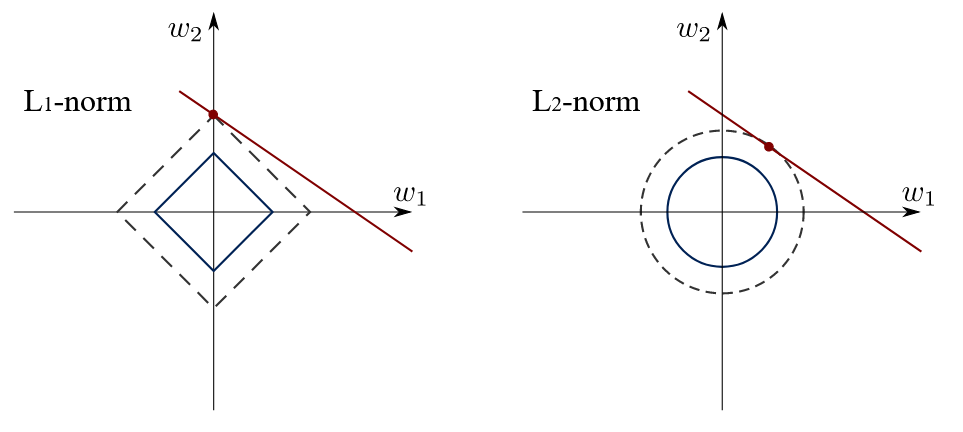

In [8]:
Image(filename = "Lasso_ridge.png")

Source: [Wikipedia](https://en.wikipedia.org/wiki/Lasso_(statistics))

#### 2.1.1 Lasso:

Since numerical methods are beyond the scope of this course, we will be using Python's `scikit-learn` library for the following exercises. 

In [9]:
# import Lasso with cross-validation
from sklearn.linear_model import LassoCV

# define the LassoCV object
Lasso = LassoCV(cv=5, fit_intercept=False, normalize=False).fit(df_std_is.iloc[:,1:], df_std_is.iloc[:,0])
print('The optimal alpha is: '+ str(Lasso.alpha_))

The optimal alpha is: 0.0046194187341294475


Let's look at the path of the coefficients.

In [10]:
# compute the path
[alphas,weights,c] = Lasso.path(df_std_is.iloc[:,1:], df_std_is.iloc[:,0])

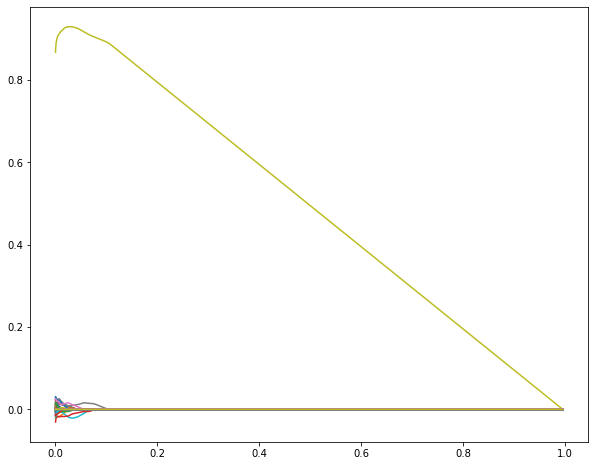

In [11]:
# plot the path
fig, ax = plt.subplots()
ax.plot(alphas, weights.T)
plt.show()

We can also display the parameters in a historgam to get an idea of the distribution of the parameters.

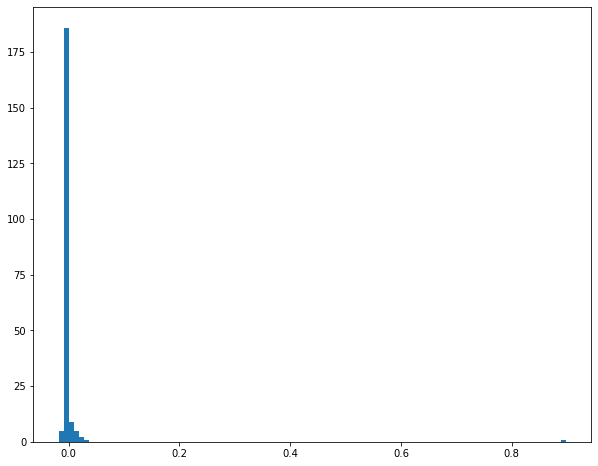

In [12]:
# plot a histogram of the model parameters
plt.hist(Lasso.coef_, bins = 100)
plt.show()

Finally, let's compute the in-sample and out-of-sample predictions. Before, we can reverse the standardization so that we are back to the original scaling.

In [13]:
# compute the Lasso in-sample predictions
y_hat_Lasso_is = Lasso.predict(df_std_is.iloc[:,1:])

# compute the Lasso out-of-sample predictions
y_hat_Lasso_oos = Lasso.predict(df_std_oos.iloc[:,1:])

# de-standardize the in-sample predictions and the outcome
y_ht_Lasso_is = y_hat_Lasso_is*np.sqrt(dt_std_is.var_[0])+dt_std_is.mean_[0]
y_yt_Lasso = np.asarray(df_std_full.iloc[:,0])*np.sqrt(dt_std_full.var_[0])+dt_std_full.mean_[0]

# de-standardize the out-of-sample predictions
y_ht_Lasso_oos = y_hat_Lasso_oos*np.sqrt(dt_std_oos.var_[0])+dt_std_oos.mean_[0]

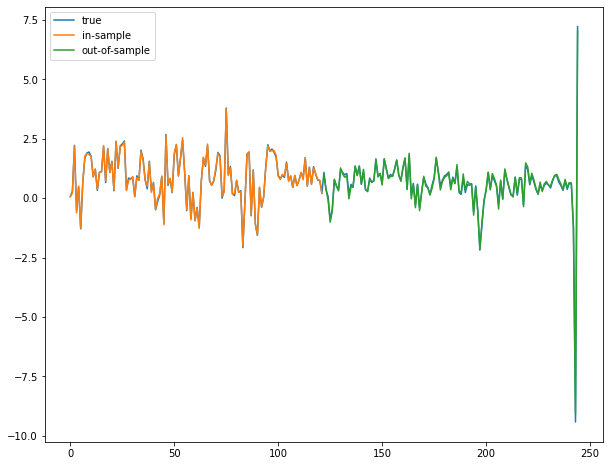

In [14]:
# Plot the Lasso prediction and the original data
fig, ax = plt.subplots()
plt.plot(np.vstack((y_yt_Lasso*100,np.hstack((y_ht_Lasso_is*100,[None]*(len(y_yt_Lasso)-len(y_ht_Lasso_is)))),np.hstack(([None]*(len(y_yt_Lasso)-len(y_ht_Lasso_oos)),y_ht_Lasso_oos*100,)))).T)
ax.legend(['true','in-sample','out-of-sample'])
plt.show()

#### 2.1.2 Ridge-Regression:

##### 2.1.2.1 Own Implementation

As pointed out above, there is an analytical solution for Ridge-Regression: 

$$
\hat{\beta_R} = (X'X + \lambda I)^{-1} X'Y
$$

With $\lambda=0$, we are back to the general OLS estimator. Before we use a `scikit-learn` implementation, let's write our own Ridge-Regression `class` for illustrative purposes.

In [15]:
class Ridge:

    """
    This code implements a simple Ridge-regression. The inputs Y and X must be in numpy array format. 
    """
    
    def __init__(self, Y, X):
        #Initialize the dependent and independent variables
        self.Y, self.X = Y, X 
        
        # terminate and produce error message, if Y or X are of wrong type
        if isinstance(X,np.ndarray) == False:
            raise TypeError('X is not a numpy ndarray!')
        if isinstance(Y,np.ndarray) == False:
            raise TypeError('Y is not a numpy ndarray!')
    
    # this is the function computing the coefficients for Ridge-regression
    def get_betas(self, λ, YY=None, XX=None):
        
        if YY is None:
            YY = self.Y
        
        if XX is None:
            XX = self.X
        
        #Estimate the beta coefficients
        self.beta = np.linalg.inv(XX.T @ XX + λ * np.eye(XX.shape[1])) @ (XX.T @ YY)
        
        self.y_hat = XX @ self.beta
        
        return self.beta
    
    # this function computes the paths of the coefficients given a grid of λs
    def beta_paths(self, grid, YY=None, XX=None):
        
        if YY is None:
            YY = self.Y
        
        if XX is None:
            XX = self.X
        
        # initialize an empty array for the paths of beta
        betas = np.empty([XX.shape[1],len(grid)])
        
        for i in range(len(grid)):
            
            # compute the betas for every grid point
            betas[:,i] = self.get_betas(grid[i], YY, XX)
            
        # store the paths
        self.betas = betas
        
        
    def CV(self, grid ,k=5):
        
        # unpack self
        Y, X = self.Y, self.X
        
        # generate arrays containing the indices of the k data chunks
        ids = list(range(len(Y)))
        chunks = np.asarray(np.array_split(np.array(ids),k),dtype=object)

        # read out the sample size
        n = list(range(len(Y)))

        # convert k into a list
        a = np.arange(k)

        # initialize out-of-sample loss
        MSE_oos = []

        # iterate over the folds to compute the CV standard error
        for i in a:

            # obtain the indeces of the data belonging to the training sample
            b_train = a[np.arange(len(a))!=i]
            subid_train = np.concatenate( chunks[b_train], axis=0 )

            # obtain the indices of the data belonging to the test sample
            b_test =  a[np.arange(len(a)) ==i]
            subid_test = np.concatenate( chunks[b_test], axis=0 )

            # devide the data into test and training samples
            Y_train = Y[subid_train]
            X_train = X[subid_train,:]
            Y_test = Y[subid_test]
            X_test = X[subid_test,:]

            # calculate the coefficient paths
            self.beta_paths(grid, Y_train, X_train)
            estimate_train = self.betas
            
            # compute the out-of-sample error
            error_oos = np.repeat(Y_test.reshape(len(Y_test),1),len(grid),axis=1) - X_test @ estimate_train
            
            # compute the MSE for each λ
            MSE_oos.append(np.mean(np.square(error_oos),axis=0))
            
        # transform to array
        MSE_oos = np.asarray(MSE_oos)
        
        # Compute expected MSE for each λ 
        self.E_MSE = np.mean(MSE_oos,0)
        
        # find λ with lowest E_MSE  
        self.lambda_ = grid[np.argmin(self.E_MSE)]
        
        # get path for lowest lambda
        self.beta_ = self.get_betas(grid[np.argmin(self.E_MSE)])
        

In [16]:
# define an object of class ridge (our own)
R1 = Ridge(np.asarray(df_std_is.iloc[:,0]),np.asarray(df_std_is.iloc[:,1:]))

Let's look at the paths for the coefficients.

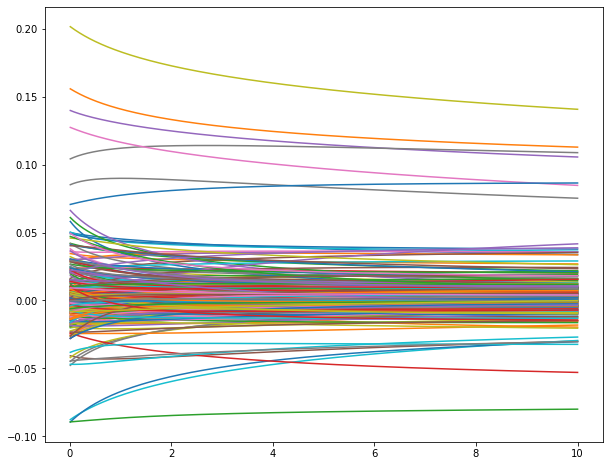

In [17]:
λs = np.arange(0.0,10.01,0.01)
R1.beta_paths(λs)

# Plot the Path of the Ridge-Regression coefficients
fig, ax = plt.subplots()
plt.plot(λs[1:], R1.betas[:,1:].T)
plt.show()

Let us now call the `CV` method to tune the $\lambda$ parameter with 5-fold cross-validation. 

In [18]:
R1.CV(λs)
print('The optimal λ is: ' + str(R1.lambda_))

The optimal λ is: 4.15


We can can also plot the expected MSE across the grid.

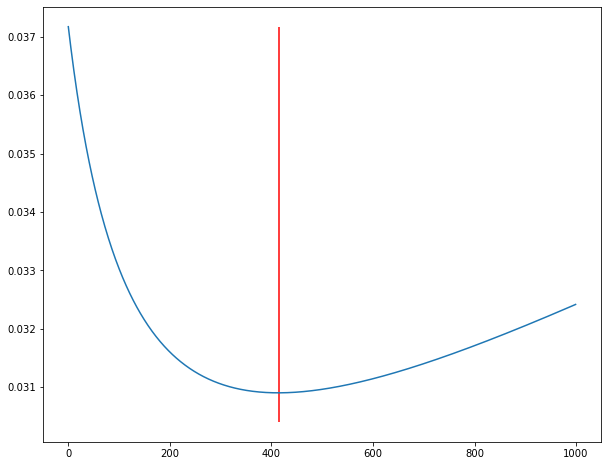

In [19]:
# Plot the Ridge prediction and the original data
fig, ax = plt.subplots()
plt.plot(R1.E_MSE[1:])
plt.vlines(np.argmin(R1.E_MSE[1:]), np.min(R1.E_MSE[1:])-0.0005, np.max(R1.E_MSE[1:]), colors='r', linestyles='solid')
plt.show()

Finally, let us again compute the de-standardized predictions and plot them together with the original data.

In [20]:
# de-standardize the in-sample predictions and the 
y_ht_R1_is = R1.y_hat*np.sqrt(dt_std_is.var_[0])+dt_std_is.mean_[0]

# de-standardize the outcome 
y_yt_R1 = np.asarray(df_std_full.iloc[:,0])*np.sqrt(dt_std_full.var_[0])+dt_std_full.mean_[0]

# generate out-of-sample predictions and de-standardize
y_hat_oos = df_std_oos.iloc[:,1:]@R1.beta_
y_ht_R1_oos = y_hat_oos*np.sqrt(dt_std_oos.var_[0])+dt_std_oos.mean_[0]


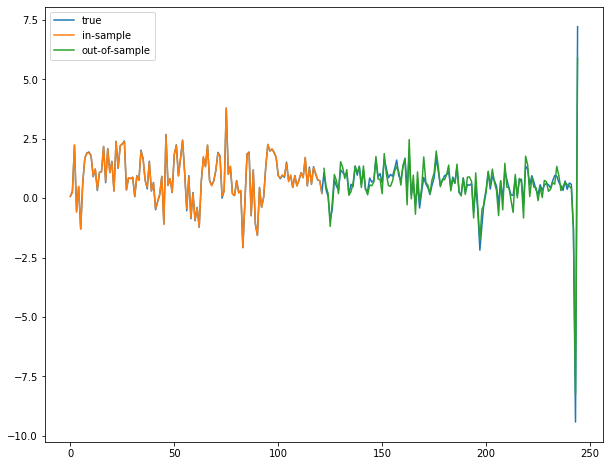

In [21]:
# Plot the Ridge prediction and the original data
fig, ax = plt.subplots()
plt.plot(np.vstack((y_yt_R1*100,np.hstack((y_ht_R1_is*100,[None]*(len(y_yt_R1)-len(y_ht_R1_is)))),np.hstack(([None]*(len(y_yt_R1)-len(y_ht_R1_oos)),y_ht_R1_oos*100,)))).T)
ax.legend(['true','in-sample','out-of-sample'])
plt.show()

##### 2.1.2.2 Implementation using Scikit-learn:

In [22]:
# import Ridge with cross-validation
from sklearn.linear_model import RidgeCV

# define the LassoCV object
R2 = RidgeCV(cv=5, fit_intercept=False, normalize=False).fit(df_std_is.iloc[:,1:], df_std_is.iloc[:,0])
print('The optimal λ is: '+ str(R2.alpha_))

The optimal λ is: 10.0


Let's compute the predicted values and plot them together with the original data.

In [23]:
# compute the Lasso in-sample predictions
y_hat_R2_is = R2.predict(df_std_is.iloc[:,1:])
y_hat_R2_oos = R2.predict(df_std_oos.iloc[:,1:])

# de-standardize the in-sample predictions
y_ht_R2_is = y_hat_R2_is*np.sqrt(dt_std_is.var_[0])+dt_std_is.mean_[0]

# de-standardize the outcome
y_yt_R2 = np.asarray(df_std_full.iloc[:,0])*np.sqrt(dt_std_full.var_[0])+dt_std_full.mean_[0]

# de-standardize the out-of-sample predictions
y_ht_R2_oos = y_hat_R2_oos*np.sqrt(dt_std_oos.var_[0])+dt_std_oos.mean_[0]

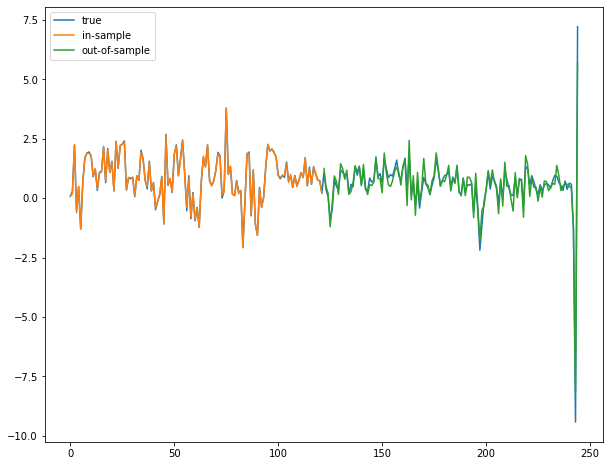

In [24]:
# Plot the Ridge prediction and the original data
fig, ax = plt.subplots()
plt.plot(np.vstack((y_yt_R2*100,np.hstack((y_ht_R2_is*100,[None]*(len(y_yt_R2)-len(y_ht_R2_is)))),np.hstack(([None]*(len(y_yt_R2)-len(y_ht_R2_oos)),y_ht_R2_oos*100,)))).T)
ax.legend(['true','in-sample','out-of-sample'])
plt.show()

Finally, let's check by how much the predictions from the package solution and our own computations differ.

In [25]:
print('The average difference in sample is: '+str(np.mean(y_ht_R1_is - y_ht_R2_is)))
print('The average difference out-of-sample is: '+str(np.mean(y_ht_R1_oos - y_ht_R2_oos)))

The average difference in sample is: -9.242379175286267e-20
The average difference out-of-sample is: -4.231032868236115e-20


This is basically zero! 

### 2.2 Principal Component Analysis (PCA):

The idea for this exercise is to extract principal components from the independent variables and to use these later in a factor augmented regression (regressions, where the independent variables contain factors).

Let's again write our own class that implements PCA. To assess the optimal number of factors, let us also use cross-validation. Note that there are many techniques of varying degrees of sofistication to assess the optimal number of factors. Their performance might differ from application to application. The only reason I use CV here, is to preserve consistency among the three exercises. You are of course free to use e.g. `Scikit-learn` to estimate the factors or to use any other scheme to select the number of factors you like.

##### 2.2.1 Own Implementation

In [26]:
class PCA:
    
    def __init__(self, X):
        self.X = X

    def get_components(self, X = None, kk = 1, λ = None):
        
        # build the function such that it can also back out the factors given the loadings for arbitrary samples
        if X is None:
            X = self.X
            
        if λ is not None:
            # back out the size of the data
            [t,n] = X.shape
            
            self.λ = λ
            self.f = X @ self.λ /n
        else:
            #X = self.X
            
            # back out the size of the data
            [t,n] = X.shape

            # since the data is standardized, we can compute the variance-covariance matrix like so
            covm = X.T @ X

            # now we extract the eigenvectors and eigenvalues
            w,v = np.linalg.eig(covm)

            # sort in descending order
            sort_id = np.flipud(np.argsort(w))
            v = v[:,sort_id]
            # diagonalize eigenvalues
            w = np.diag(w[sort_id])
    
            # compute the factor loadings
            self.λ = np.sqrt(n)*v[:,0:kk]

            # compute the principal components
            self.f = X @ self.λ /n

        return self.f.real, self.λ.real
    
    def get_betas(self, Y, X = None, f = None, kk=1):
        
        if f is None:
        # extract kk factors
            f, l = self.get_components(X, kk) 
        
        # compute OLS coefficients in factor augmented regression
        betas = np.linalg.inv(f.T @ f) @ (f.T @ Y)
    
        return betas
        
    def get_predictions_CV(self, Y_train, Y_test, X_train, X_test, max_k):
        
        MSE = np.empty([1, max_k])
        
        for i in range(1,max_k+1):
            
            # compute principal components of training data
            f_train, λ_train = self.get_components(X_train, i)
            
            # compute the betas for the training data
            betas_train = self.get_betas(Y_train, None, f_train.real, i)
        
            # compute the factors for the test data based on the loading for the training data
            f_test, λ_test = self.get_components(X_test, i, λ_train.real)
            
            # compute the predictions of the test data
            y_hat_test = f_test @ betas_train
            
            # compute out-of-sample error of test data
            oos = Y_test - y_hat_test
            
            # compute MSE for oos
            MSE[0,i-1] = np.mean(oos**2)
            
        return MSE #, y_hat_test
            
    def CV(self, Y, X, max_k ,k=5):
        
        # generate arrays containing the indices of the k data chunks
        ids = list(range(len(Y)))
        chunks = np.asarray(np.array_split(np.array(ids),k),dtype=object)

        # read out the sample size
        n = list(range(len(Y)))

        # convert k into a list
        a = np.arange(k)

        # initialize out-of-sample loss
        MSE_oos = []

        # iterate over the folds to compute the CV standard error
        for i in a:

            # obtain the indeces of the data belonging to the training sample
            b_train = a[np.arange(len(a))!=i]
            subid_train = np.concatenate( chunks[b_train], axis=0 )

            # obtain the indices of the data belonging to the test sample
            b_test =  a[np.arange(len(a)) ==i]
            subid_test = np.concatenate( chunks[b_test], axis=0 )

            # devide the data into test and training samples
            Y_train = Y[subid_train]
            X_train = X[subid_train,:]
            Y_test = Y[subid_test]
            X_test = X[subid_test,:]

            # calculate the MSEs for all k
            MSE = self.get_predictions_CV(Y_train, Y_test, X_train, X_test, max_k)
            
            # compute the MSE for each λ
            MSE_oos.append(MSE)
            
        # transform to array
        MSE_oos = np.asarray(MSE_oos)
    
        # Compute expected MSE for each λ 
        self.E_MSE = np.mean(MSE_oos,0)
        
        # find k with lowest E_MSE  
        self.k_ = np.argmin(self.E_MSE)
        
        # get betas for optimal number of factors
        self.beta_ = self.get_betas(Y, X, None, self.k_)
        
        # get factors
        self.f_ = self.f
        
        # get predictions
        self.yhat_ = self.f_ @ self.beta_

Before we turn to out-of-sample forecasting, let us first build some intuition and use this class to extract factors/principal components for the entire sample.

In [27]:
%%capture

# define PCA class in-sample object
PCA1_full = PCA(np.asarray(df_std_full.iloc[:,1:]))

k = 3 
PCA1_full.get_components(np.asarray(df_std_full.iloc[:,1:]),k)

We can plot the three principal components that we just extracted together with the original data. This gives us an idea of what kind of information they might contain and how well they fit the GDP series.

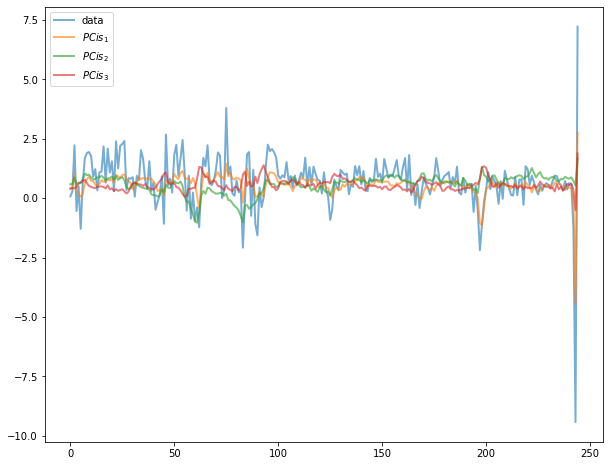

In [28]:
f_PCA1_full = PCA1_full.f.real*np.sqrt(dt_std_is.var_[0])+dt_std_oos.mean_[0]

fig, ax = plt.subplots()

ax.plot(y_yt_R2*100, linewidth=2, alpha=0.6, label='data')
for i in range(k):
    current_label = f'$PC is_{i+1}$'
    ax.plot(f_PCA1_full[:,i]*100, linewidth=2, alpha=0.6, label=current_label)
ax.legend()
plt.show()

Let us now use CV to assess the optimal number of factors. The problem is that we assess performance with OLS. We have fewer observations than variables, however. I thus limit the maximal number of factors to 100.

In [29]:
k_max = 100

PCA1_is = PCA(np.asarray(df_std_is.iloc[:,1:]))
PCA1_is.CV(np.asarray(df_std_is.iloc[:,0]),np.asarray(df_std_is.iloc[:,1:]),k_max,5)

print('The optimal number of factors is: ' + str(PCA1_is.k_))

The optimal number of factors is: 89


Again, we can look at the expected MSE for each CV step (number of factors). Note that I omitted the last three MSEs as they increase rapidly, blowing up the scale.

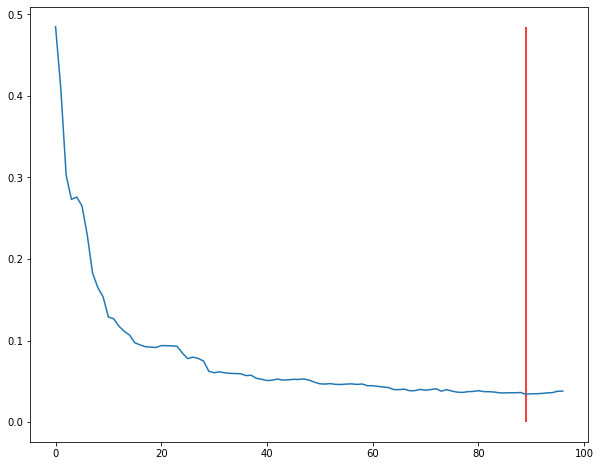

In [30]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Plot the Ridge prediction and the original data
fig, ax = plt.subplots()
plt.plot(PCA1_is.E_MSE.ravel()[:-3])
plt.vlines(89, 0, np.max(PCA1_is.E_MSE.ravel()[:-3]), colors='r', linestyles='solid')
plt.show()


Using the optimal number of factors, we can now plot the predictions together with the original data.

In [31]:
k = PCA1_is.k_

# compute the in-sample and out-of-sample factors
f_is, λ_is = PCA1_is.get_components(np.asarray(df_std_is.iloc[:,1:]),k)
f_oos, λ_oos = PCA1_is.get_components(np.asarray(df_std_oos.iloc[:,1:]),None, λ_is)

beta_is = PCA1_is.get_betas((df_std_is.iloc[:,0]), None, f_is, None)
beta_oos = PCA1_is.get_betas((df_std_oos.iloc[:,0]), None, f_oos, None)

y_hat_PCA1_is = f_is @ beta_is
y_hat_PCA1_oos = f_oos @ beta_oos

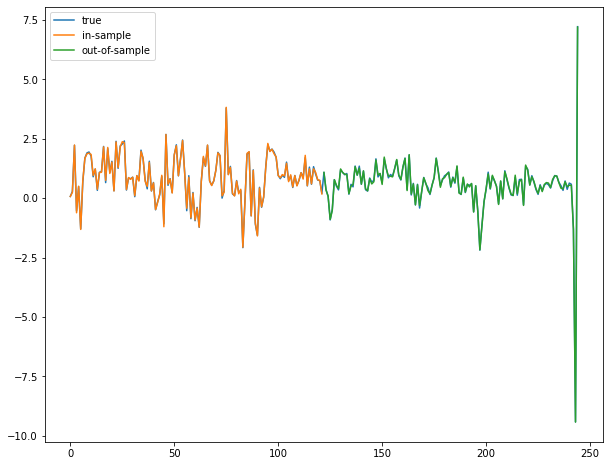

In [32]:
# de-standardize the in-sample predictions 
y_ht_PCA1_is = y_hat_PCA1_is*np.sqrt(dt_std_is.var_[0])+dt_std_is.mean_[0]
y_ht_PCA1_oos = y_hat_PCA1_oos*np.sqrt(dt_std_oos.var_[0])+dt_std_oos.mean_[0]

# Plot the PCA prediction and the original data
fig, ax = plt.subplots()
plt.plot(np.vstack((y_yt_R2*100,np.hstack((y_ht_PCA1_is*100,[None]*(len(y_yt_R2)-len(y_ht_PCA1_is)))),np.hstack(([None]*(len(y_yt_R2)-len(y_ht_PCA1_oos)),y_ht_PCA1_oos*100,)))).T)
ax.legend(['true','in-sample','out-of-sample'])
plt.show()

### 3.0 Recession Forecasting and ROC curve:

In the last part of this tutorial, we are going look at ROC curves for all three models. First, we are going to find the actual recession in the sample (based on the GDP growth data). The idea then is to use all of the previous approaches and a cut-off rule (for contemporaneous GDP predictions), to produce a recession forecast. Note, this exercise is of course highly simplified/stylized. We are then going to compute the true-positive and false-positive rate to produce a ROC curve. 

Before we test our models on a recession classification that is closer to the truth, let's assume the economy is in recession whenever growth is below 0%.


In [33]:
recession1 = []

for i in range(y_yt_R1.shape[0]-1):
    
    if y_yt_R1[i] < 0:
        recession1.append(1)
    else: 
        recession1.append(-1)
        
recession1.append(-1)

recession1_is = recession1[:y_ht_PCA1_is.shape[0]]
recession1_oos = recession1[y_ht_PCA1_is.shape[0]:]

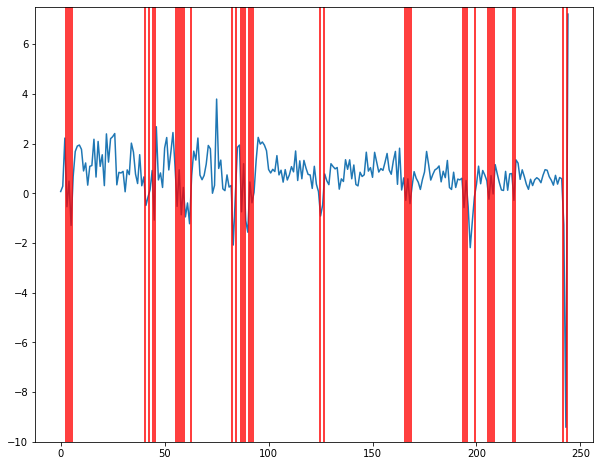

In [34]:
# plot the time periods with the recessions
fig, ax = plt.subplots()
ax.plot(y_yt_R1*100)
ax.plot(np.asarray(recession1).T*1000000, color='red')
ax.set_ylim([-10,7.5])
plt.show()

With the recessions classified, we can now compute the true-positive and false-positive rates of all three approaches, Lasso, Ridge, and PCA. For convenience, let's cast the computations into a function.

The idea is the following. All models produce predictions of GDP growth (Note that we could have used a binary classification model to predict recessions instead). The question now is, which cut-off level should we use to "convert" the GDP growth prediction into a recession forecast. It could for example be that we achieve better performance, if we only predict a recession, if a model predicts e.g. +0.2% or -0.5% GDP growth. Optimizing a cut-off thus let's us tweak the sensitivity of the model. For each of these cut-off levels, we then compute the true-positive and false-positive rates. 

In [35]:
def ROC(prediction, data):

    gammas = np.arange(max(prediction)+0.001,min(prediction)-0.001,-0.0001)

    TPR = []
    FPR = []
    for i in gammas:
        recs = prediction < i 
        match = data-recs

        #breakpoint()
        FP = sum(match == -2)
        TP = sum(match == 0)

        TPR.append(TP/(sum(np.asarray(data)==1)))
        FPR.append(FP/(sum(np.asarray(data)==-1)))
        
    return TPR, FPR

With the function in place, we can easily compute the ROCs for all models that we used above.

In [36]:
# call the function for all models
TPR_Lasso, FPR_Lasso = ROC(y_ht_Lasso_is, recession1_is)
TPR_R1, FPR_R1 = ROC(y_ht_R1_is, recession1_is)
TPR_PCA1, FPR_PCA1 = ROC(y_ht_PCA1_is, recession1_is)


Having called the function, we can now plot the ROCs.

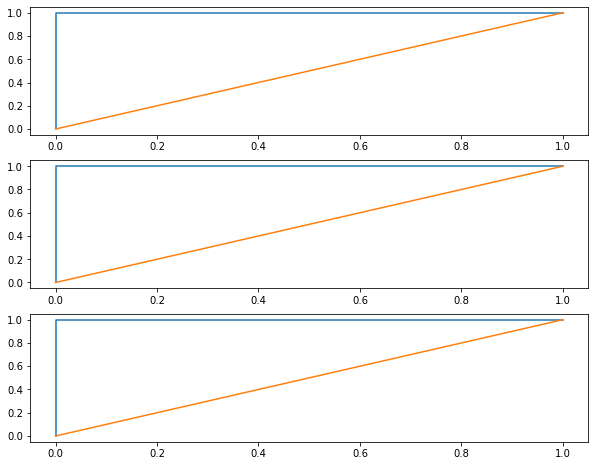

In [37]:
fig, ax = plt.subplots(3)
ax[0].plot(FPR_Lasso,TPR_Lasso)
ax[0].plot(FPR_Lasso,FPR_Lasso)
ax[1].plot(FPR_R1,TPR_R1)
ax[1].plot(FPR_R1,FPR_R1)
ax[2].plot(FPR_PCA1,TPR_PCA1)
ax[2].plot(FPR_PCA1,FPR_PCA1)
plt.show()

For this very simple cut-off rule, all models are perfect classifiers. We can now use the out-of-sample predictions instead to test the models' out-of-sample performance.


In [38]:
# call the function for all models
TPR_Lasso, FPR_Lasso = ROC(y_ht_Lasso_oos, recession1_oos)
TPR_R1, FPR_R1 = ROC(y_ht_R1_oos, recession1_oos)
TPR_PCA1, FPR_PCA1 = ROC(y_ht_PCA1_oos, recession1_oos)


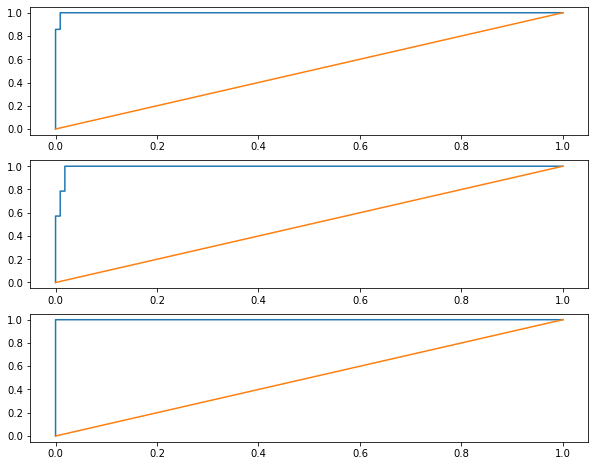

In [39]:
fig, ax = plt.subplots(3)
ax[0].plot(FPR_Lasso,TPR_Lasso)
ax[0].plot(FPR_Lasso,FPR_Lasso)
ax[1].plot(FPR_R1,TPR_R1)
ax[1].plot(FPR_R1,FPR_R1)
ax[2].plot(FPR_PCA1,TPR_PCA1)
ax[2].plot(FPR_PCA1,FPR_PCA1)
plt.show()

Now Lasso and Ridge perform slightly worse. PCA still seems to do a good job. 

Let us now check what happens if we use a different classification rule. As a rule of thumb, in practice we often classify a recession as two consecutive quarters of negative GDP growth. Let's use this more realistic definition instead and evaluate how our models perform.


In [40]:
recession2 = []

for i in range(y_yt_R1.shape[0]-1):
    
    if y_yt_R1[i] < 0 and y_yt_R1[i+1] < 0:
        recession2.append(1)
    elif y_yt_R1[i-1] < 0 and y_yt_R1[i] < 0:
        recession2.append(1)
    else: 
        recession2.append(-1)
        
recession2.append(-1)

recession2_is = recession2[:y_ht_PCA1_is.shape[0]]
recession2_oos = recession2[y_ht_PCA1_is.shape[0]:]

indices = [i for i, x in enumerate(recession2) if x == 1]
indices

[41, 42, 60, 61, 62, 83, 84, 89, 90, 125, 126, 196, 197, 198, 199, 242, 243]

For illustration, let's again look at the data and the recessions following the new definition.

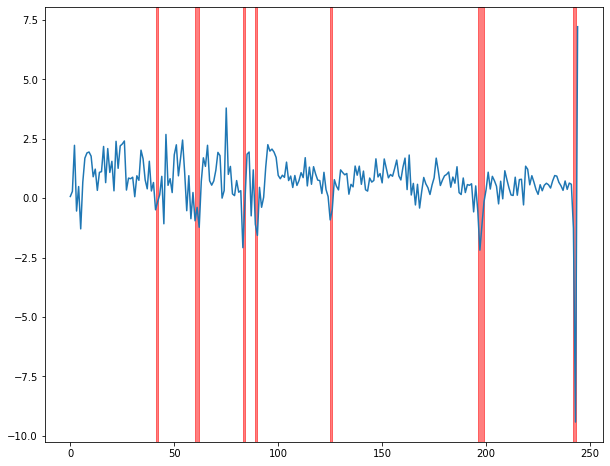

In [41]:
# plot a histogram of the model parameters
fig, ax = plt.subplots()
ax.plot(y_yt_R1*100)
ax.axvspan(41, 42, alpha=0.5, color='red')
ax.axvspan(60, 62, alpha=0.5, color='red')
ax.axvspan(83, 84, alpha=0.5, color='red')
ax.axvspan(89, 90, alpha=0.5, color='red')
ax.axvspan(125, 126, alpha=0.5, color='red')
ax.axvspan(196, 199, alpha=0.5, color='red')
ax.axvspan(242, 243, alpha=0.5, color='red')

Again, compute the ROCs.

In [42]:
# call the function for all models
TPR_Lasso, FPR_Lasso = ROC(y_ht_Lasso_is, recession2_is)
TPR_R1, FPR_R1 = ROC(y_ht_R1_is, recession2_is)
TPR_PCA1, FPR_PCA1 = ROC(y_ht_PCA1_is, recession2_is)


Finally, plot the ROCS.

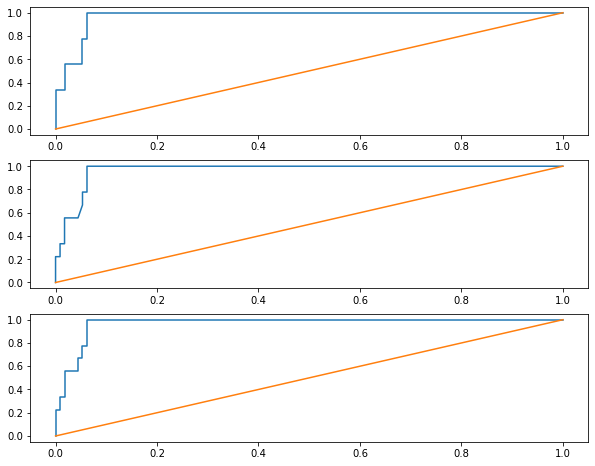

In [43]:
fig, ax = plt.subplots(3)
ax[0].plot(FPR_Lasso,TPR_Lasso)
ax[0].plot(FPR_Lasso,FPR_Lasso)
ax[1].plot(FPR_R1,TPR_R1)
ax[1].plot(FPR_R1,FPR_R1)
ax[2].plot(FPR_PCA1,TPR_PCA1)
ax[2].plot(FPR_PCA1,FPR_PCA1)
plt.show()

With the new definition, the models no longer classify recessions perfectly. They are, however, still far superior to e.g. a random classifier (the diagonal).

Let us again look at the out-of-sample performance. 

In [44]:
# call the function for all models
TPR_Lasso, FPR_Lasso = ROC(y_ht_Lasso_oos, recession2_oos)
TPR_R1, FPR_R1 = ROC(y_ht_R1_oos, recession2_oos)
TPR_PCA1, FPR_PCA1 = ROC(y_ht_PCA1_oos, recession2_oos)


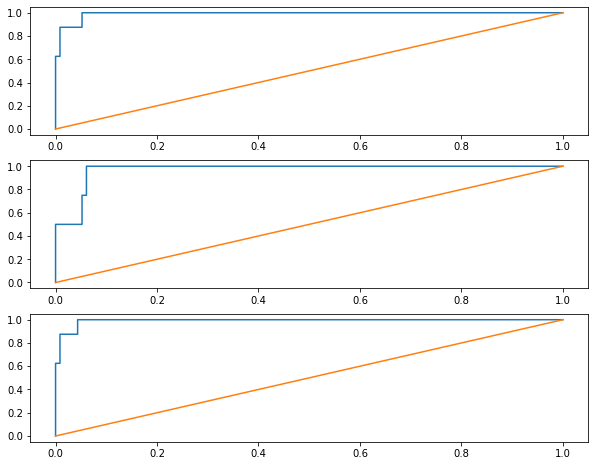

In [45]:
fig, ax = plt.subplots(3)
ax[0].plot(FPR_Lasso,TPR_Lasso)
ax[0].plot(FPR_Lasso,FPR_Lasso)
ax[1].plot(FPR_R1,TPR_R1)
ax[1].plot(FPR_R1,FPR_R1)
ax[2].plot(FPR_PCA1,TPR_PCA1)
ax[2].plot(FPR_PCA1,FPR_PCA1)
plt.show()

All models do a good job out-of-sample as well. They do even slightly better. We have to keep in mind though, that there are only few recessions in the test sample. 

## Questions for Review:

* What is the difference between Lasso and Ridge-regression?
* Why does Lasso set coefficients to zero, while Ridge-regression generally does not?
* Why does Lasso not have a closed-form solution? Why does Ridge-regression have one?
* How does CV help us to optimize the bias-variance trade-off? 
* Why do we have to standardize the data before applying Lasso, Ridge-regression, or PCA?
* Can we generally interpret the principal components extracted with PCA?
* What does the ROC-curve display?
* What is the cut-off rule in this case?
* How do we compute true-positive and false-positive rates for our recession forecasts? (Not mathematically, rather the procedure)
* Why are all models perfect classifiers following the first definition for recessions? Why does this change using the second definition?
